In [1]:
# =========== IMPORT LIBRARIES ============
import utils as ut

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from tqdm import tqdm
import itertools 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from sklearn.base import BaseEstimator, RegressorMixin

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.layers import Dropout
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
# import keras_tuner as kt
from sklearn.ensemble import RandomForestRegressor

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


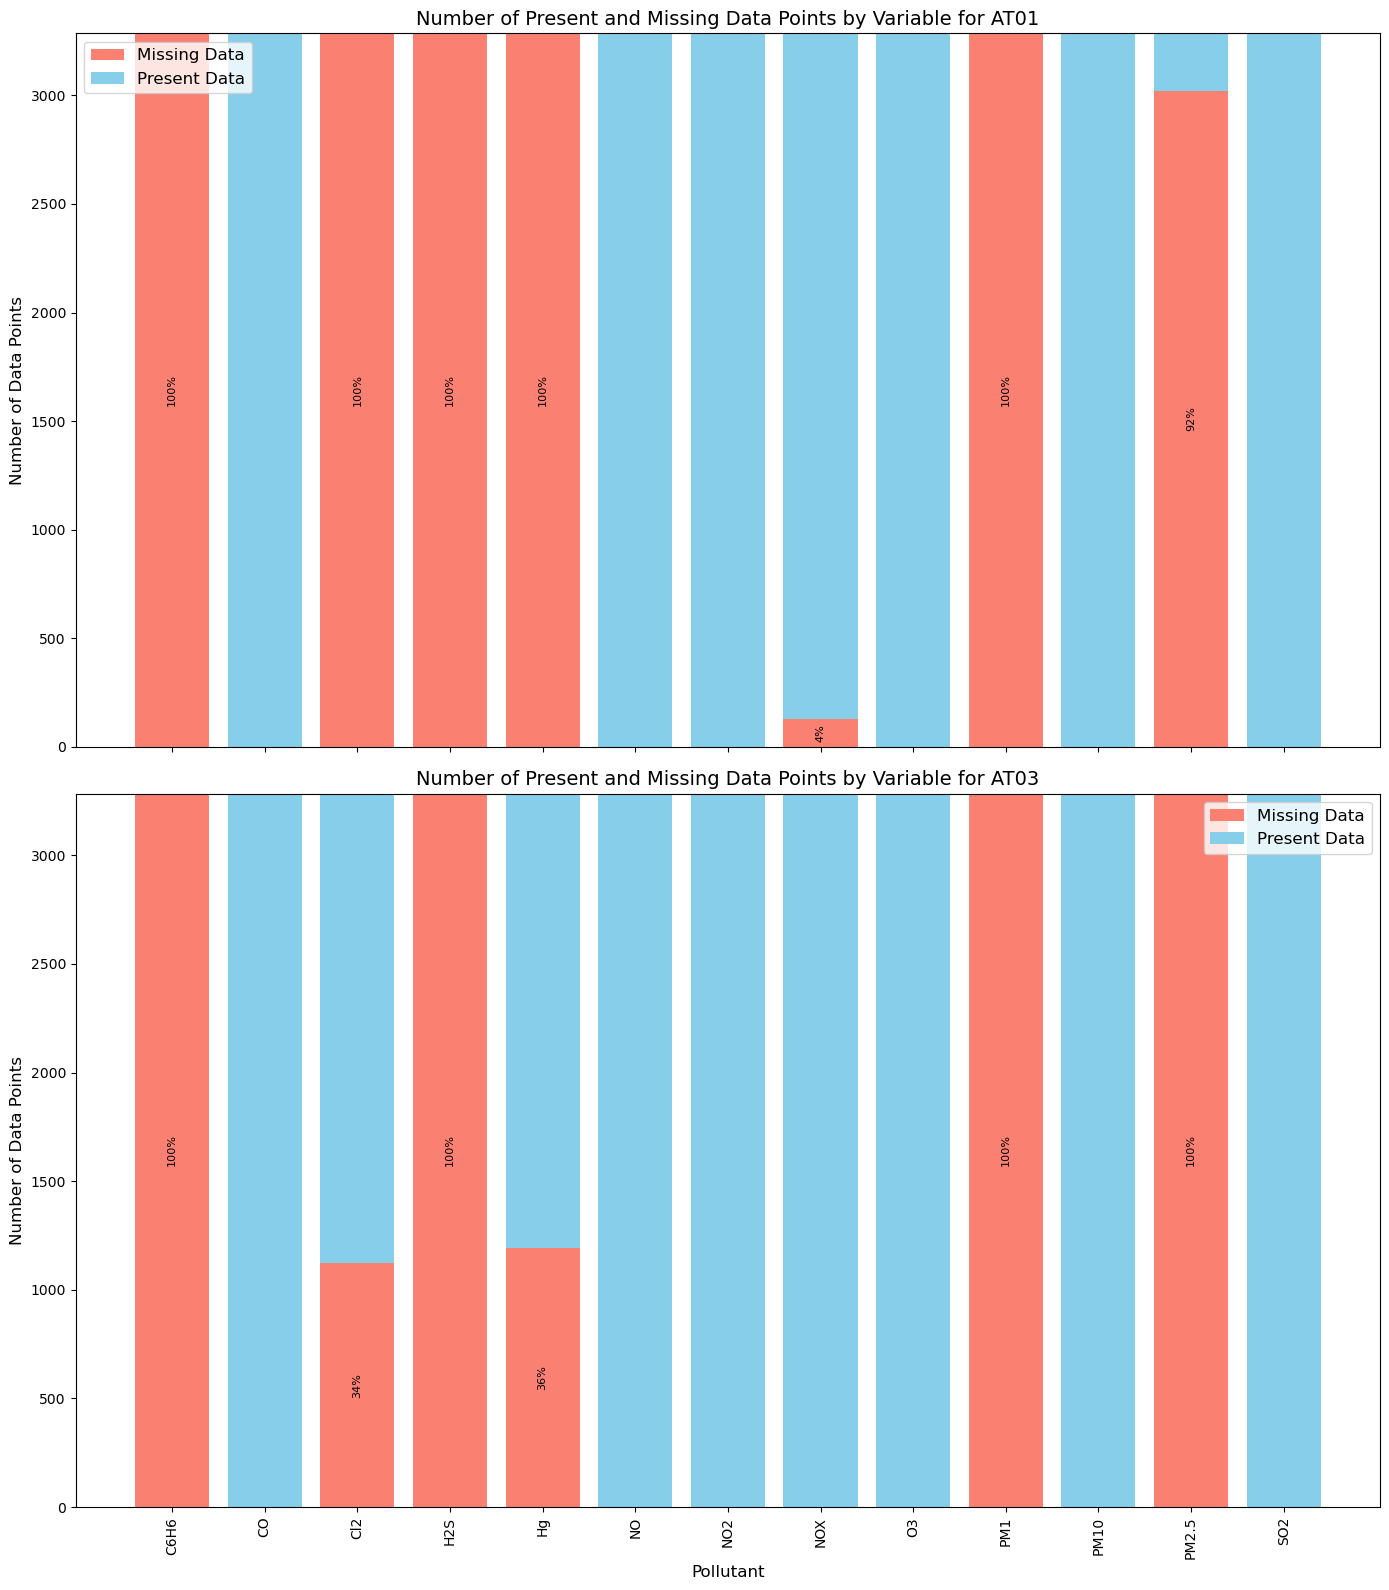

In [2]:
# =========== MISSING VALUES ============
file_path = 'modelling_data/data.csv'
at_codes = ['AT01', 'AT03']
ut.data_missing_plot(file_path, at_codes)

In [3]:
# =========== DATA SPLIT ============
data = pd.read_csv('modelling_data/weekly_data.csv')
data.date = pd.to_datetime(data.date)
# Filter data for AT01 and AT03
data_at01 = data[data['at_code'] == 'AT01']
data_at03 = data[data['at_code'] == 'AT03']
data_at01_mix = ut.data_split(data_at01, 'mix')
data_at03_mix = ut.data_split(data_at03, 'mix')

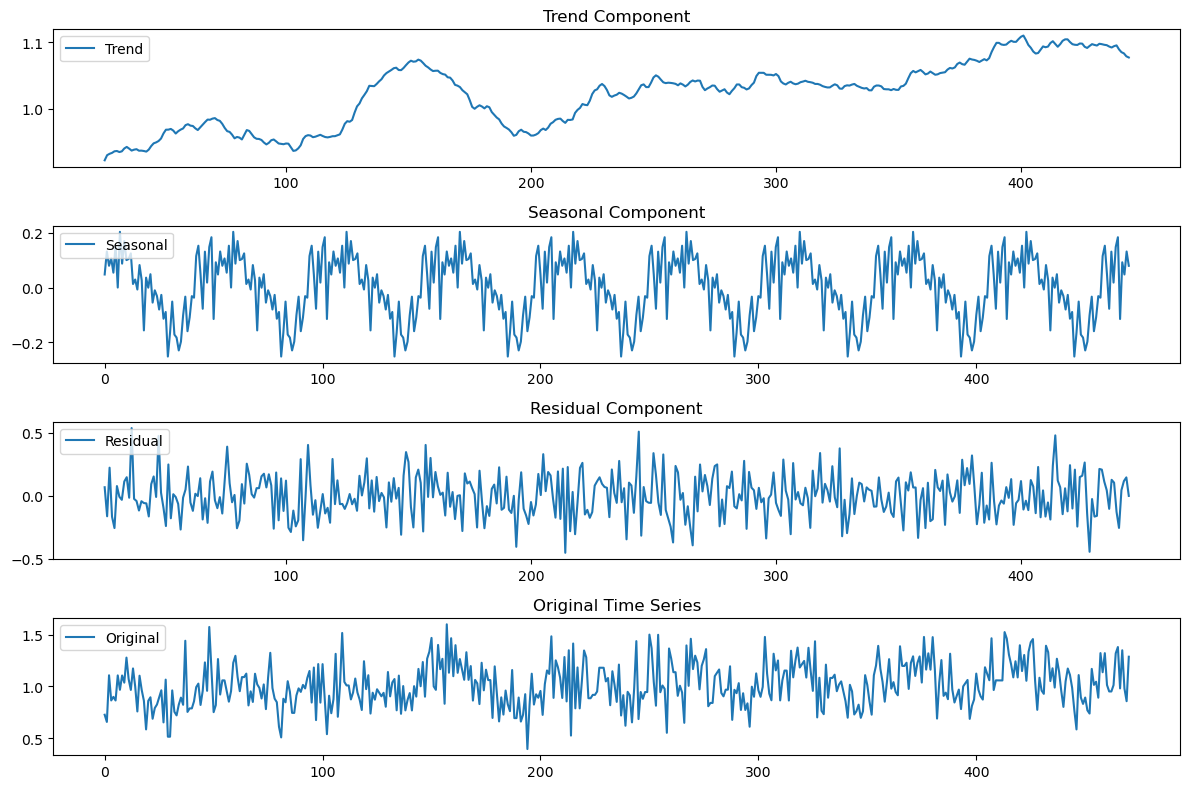

In [4]:
# =========== TIME SERIES DECOMPOSITION ============
ut.time_series_decompose_and_plot(data_at01_mix, 'AT01', 'asir')
#ut.time_series_decompose_and_plot(data_at03_mix, 'AT03', 'asir')

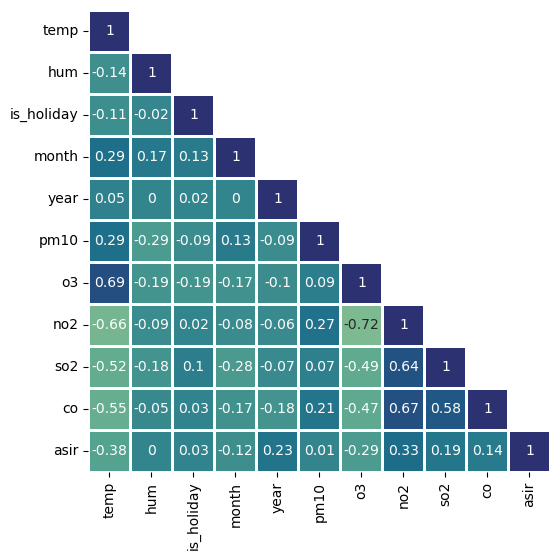

In [5]:
Y = data_at01_mix[['asir']]
X = data_at01_mix[['temp', 'hum', 'is_holiday', 'month',
       'year', 'pm10', 'o3', 'no2', 'so2', 'co']]

# =========== SCALING ============
# Store the original index before scaling
original_index = Y.index

# Separate the features and the target
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(X)

# Scale the target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(Y)

# Create scaled DataFrame for train/test split
df_f_scaled = pd.DataFrame(scaled_features, index=original_index, columns=X.columns)
df_f_scaled['asir'] = scaled_target

# =========== BIVARIATE CORRELATION MATRIX ===========

ut.corrMat(df_f_scaled, 'AT01')

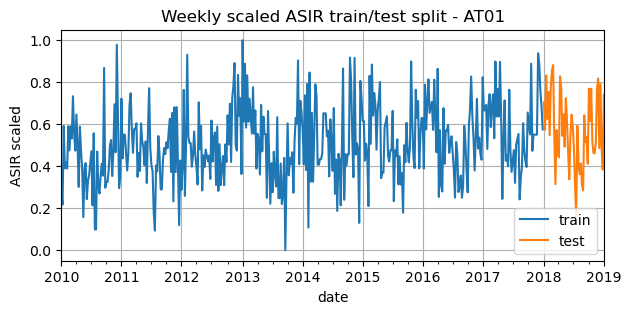

In [6]:
# =========== TRAIN/TEST SPLIT ============
# Create a date column and set it as the index
df_f_scaled['date'] = pd.to_datetime(data_at01['date'].values)
df_f_scaled.set_index('date', inplace=True)

# Filter the data for the year 2018
train = df_f_scaled[df_f_scaled.index.year < 2018]

# Filter the data from the year 2018 onwards
validation = df_f_scaled[df_f_scaled.index.year >= 2018]

ut.train_test_split(train, validation, 'AT01')

In [7]:

# =========== STATIONARITY CHECK ============
dftest = adfuller(df_f_scaled.asir, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Test statistic = -5.144
P-value = 0.000
Critical values :
	1%: -3.4444914328761977 - The data is  stationary with 99% confidence
	5%: -2.8677756786103683 - The data is  stationary with 95% confidence
	10%: -2.570091378194011 - The data is  stationary with 90% confidence


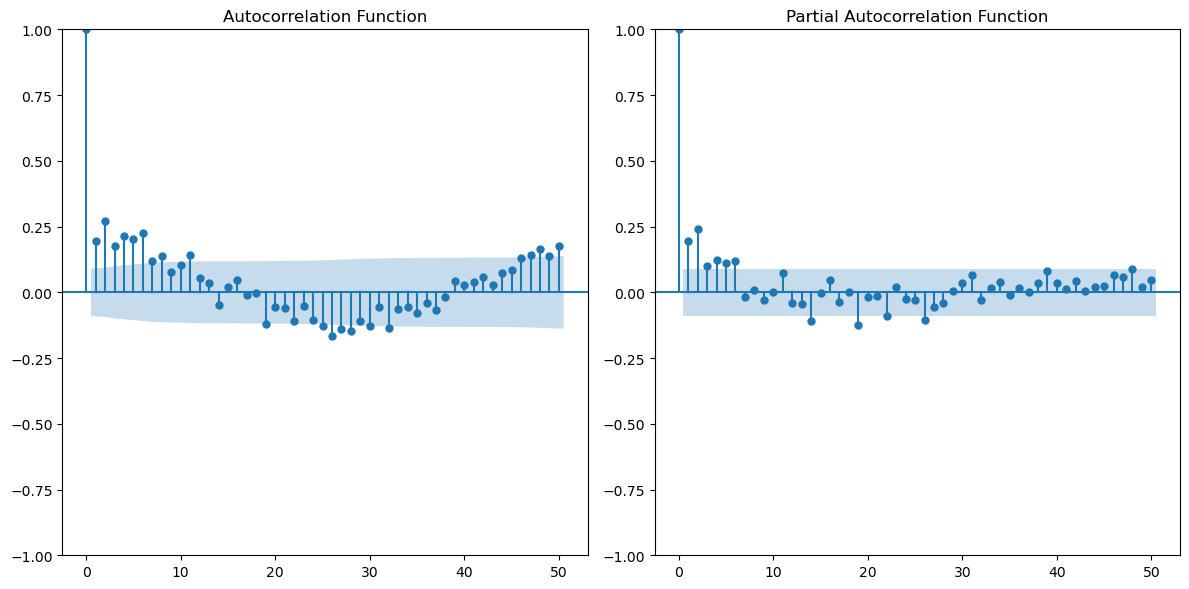

In [8]:
# # =========== PLOT ACF AND PACF OF TARGET ============
ut.plot_acf_pacf(df_f_scaled, 'AT01')

In [9]:
# # =========== AUTO ARIMA ============
# # Fit auto ARIMA model
# auto_model = pm.auto_arima(train['asir'], seasonal=True, m=52)  
# # Print the summary of the model
# print(auto_model.summary())

# #                                       SARIMA Results (AT01)                                      
# # ===========================================================================================
# # Dep. Variable:                                   y   No. Observations:                  418
# # Model:             SARIMAX(1, 1, 1)x(2, 0, [], 52)   Log Likelihood                 154.994
# # Date:                             Thu, 20 Jun 2024   AIC                           -299.988
# # Time:                                     12:51:37   BIC                           -279.823
# # Sample:                                 01-03-2010   HQIC                          -292.015
# #                                       - 12-31-2017                                         
# # Covariance Type:                               opg                                         
# # ==============================================================================
# #                  coef    std err          z      P>|z|      [0.025      0.975]
# # ------------------------------------------------------------------------------
# # ar.L1         -0.0906      0.056     -1.628      0.104      -0.200       0.018
# # ma.L1         -0.8190      0.034    -23.778      0.000      -0.887      -0.752
# # ar.S.L52       0.1423      0.052      2.749      0.006       0.041       0.244
# # ar.S.L104      0.0802      0.057      1.419      0.156      -0.031       0.191
# # sigma2         0.0276      0.002     14.911      0.000       0.024       0.031
# # ===================================================================================
# # Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.27
# # Prob(Q):                              0.98   Prob(JB):                         0.12
# # Heteroskedasticity (H):               0.95   Skew:                             0.23
# # Prob(H) (two-sided):                  0.78   Kurtosis:                         3.20
# # ===================================================================================

# #                                SARIMA Results (AT03)                                                                      
# # ==============================================================================
# # Dep. Variable:                      y   No. Observations:                  417
# # Model:               SARIMAX(5, 1, 1)   Log Likelihood                 190.660
# # Date:                Fri, 21 Jun 2024   AIC                           -367.320
# # Time:                        10:59:55   BIC                           -339.105
# # Sample:                    01-10-2010   HQIC                          -356.164
# #                          - 12-31-2017                                         
# # Covariance Type:                  opg                                         
# # ==============================================================================
# #                  coef    std err          z      P>|z|      [0.025      0.975]
# # ------------------------------------------------------------------------------
# # ar.L1          0.0408      0.056      0.727      0.467      -0.069       0.151
# # ar.L2         -0.0459      0.052     -0.883      0.377      -0.148       0.056
# # ar.L3         -0.0243      0.052     -0.472      0.637      -0.125       0.077
# # ar.L4         -0.0195      0.052     -0.373      0.709      -0.122       0.083
# # ar.L5         -0.0904      0.048     -1.881      0.060      -0.185       0.004
# # ma.L1         -0.9648      0.016    -60.591      0.000      -0.996      -0.934
# # sigma2         0.0232      0.001     18.651      0.000       0.021       0.026
# # ===================================================================================
# # Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               108.03
# # Prob(Q):                              0.94   Prob(JB):                         0.00
# # Heteroskedasticity (H):               1.71   Skew:                             0.92
# # Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
# # ===================================================================================

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50333D-01    |proj g|=  3.37343D-01

At iterate    5    f= -3.55387D-01    |proj g|=  3.81398D-01

At iterate   10    f= -3.68137D-01    |proj g|=  3.91855D-01

At iterate   15    f= -3.70797D-01    |proj g|=  1.14972D-03

At iterate   20    f= -3.70799D-01    |proj g|=  1.84262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.024D-04  -3.708D-01
  F = -0.37079904028864541     

CONVERG

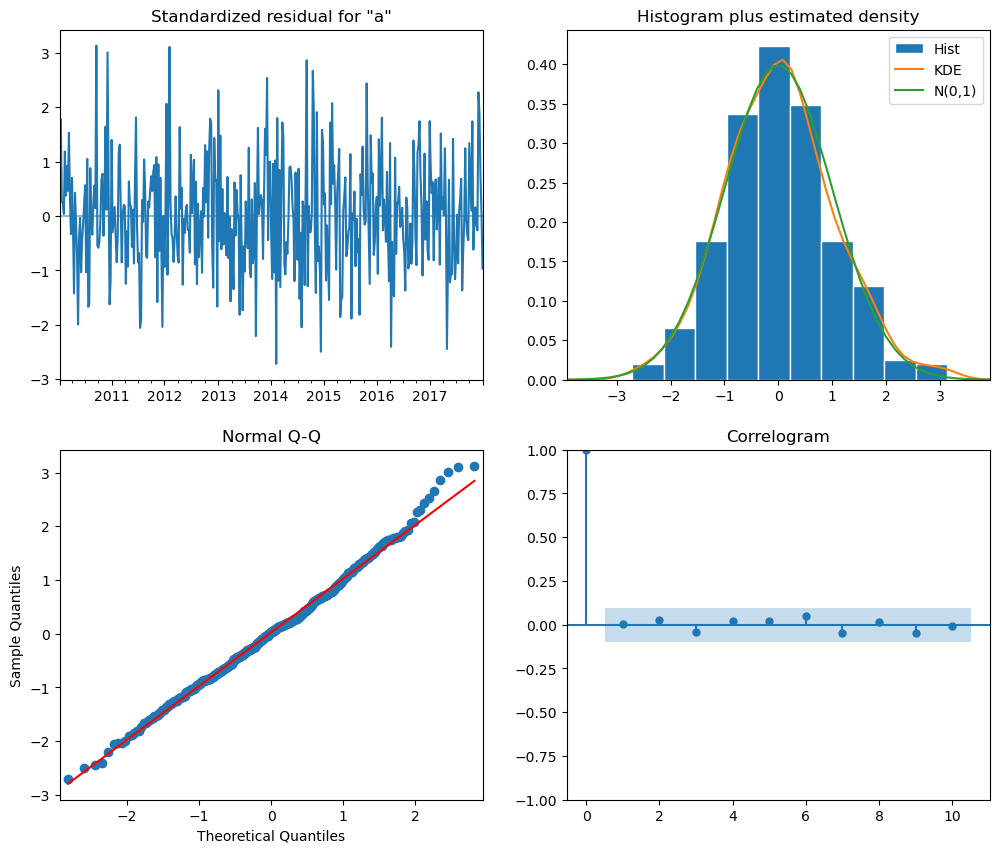

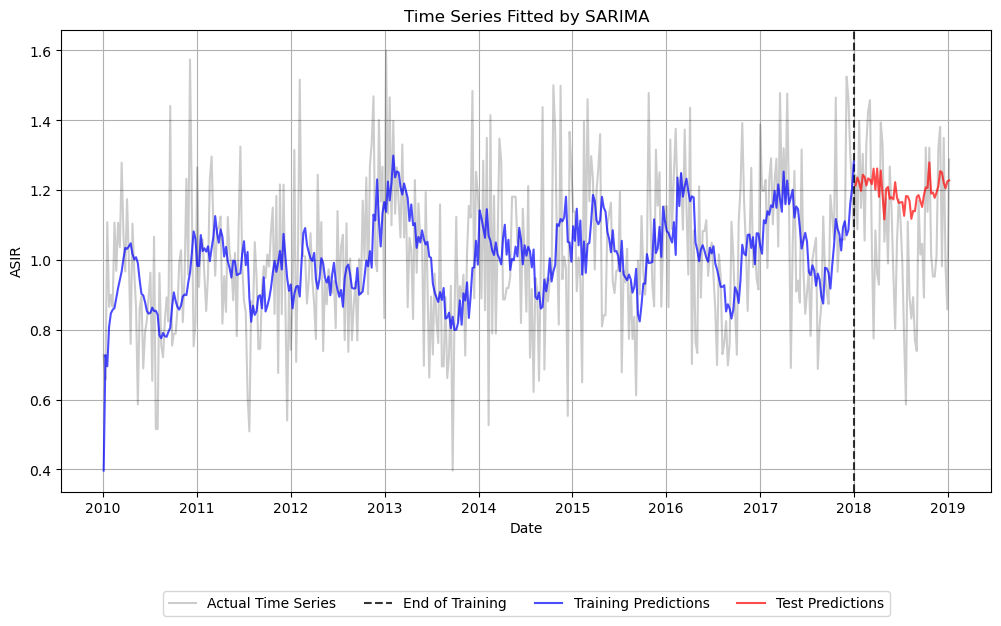

In [10]:
# ===========  SARIMA MODEL ============
order = (1, 1, 1)  # ARIMA order
seasonal_order = (2, 0, 0, 52)  # Seasonal order

# Fit the SARIMA model without exogenous data
model = SARIMAX(train['asir'], order = order, seasonal_order = seasonal_order)
results = model.fit()

# Print the model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(12, 10))
plt.savefig('plots/AT01_residuals_diag_sarima.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Make predictions for training data
train_forecast = results.get_prediction(start=train.index[0], end=train.index[-1])
train_forecast_values = train_forecast.predicted_mean
train_forecast_values_original_scale = target_scaler.inverse_transform(train_forecast_values.values.reshape(-1, 1))

# Make predictions for validation data
forecast = results.get_forecast(steps=len(validation))
forecast_values = forecast.predicted_mean
forecast_values_original_scale = target_scaler.inverse_transform(forecast_values.values.reshape(-1, 1))

# Plot actual data
plt.figure(figsize=(12, 6))
plt.plot(data_at01.date, data_at01_mix['asir'], label='Actual Time Series', color='black', alpha=0.2)

# Add vertical line at the end of train
plt.axvline(train.index[-1], color='k', linestyle='--', label='End of Training', alpha=0.8)

# Plot forecasted values for training data
plt.plot(train_forecast_values.index, train_forecast_values_original_scale, label='Training Predictions', color='blue', alpha=0.7)

# Plot forecasted values for validation data
plt.plot(forecast_values.index, forecast_values_original_scale, label='Test Predictions', color='red', alpha=0.7)

# Specify any additional plot settings
plt.xlabel('Date')
plt.ylabel('ASIR')
plt.title('Time Series Fitted by SARIMA')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)  # ncol sets the number of columns in the legend
plt.savefig('plots/AT01_sarima_forecast.pdf', format='pdf', bbox_inches='tight')
# Show plot
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.55001D-01    |proj g|=  3.28727D-01

At iterate    5    f= -3.76411D-01    |proj g|=  8.70368D-01

At iterate   10    f= -4.07436D-01    |proj g|=  2.67433D-01

At iterate   15    f= -4.26202D-01    |proj g|=  2.45091D-01

At iterate   20    f= -4.34127D-01    |proj g|=  1.05143D-01

At iterate   25    f= -4.37511D-01    |proj g|=  3.47871D-02

At iterate   30    f= -4.37926D-01    |proj g|=  1.30043D-02

At iterate   35    f= -4.37975D-01    |proj g|=  1.32047D-03

At iterate   40    f= -4.37980D-01    |proj g|=  3.84353D-03

At iterate   45    f= -4.37982D-01    |proj g|=  2.68541D-04

At iterate   50    f= -4.37982D-01    |proj g|=  6.26345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

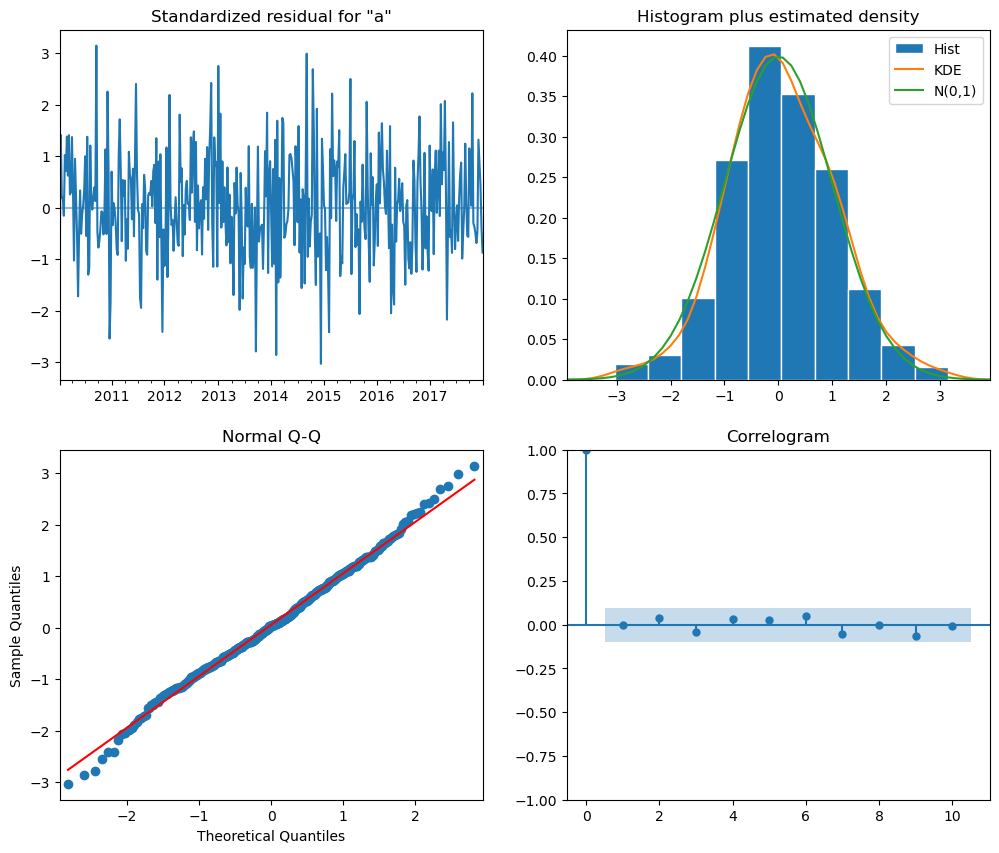

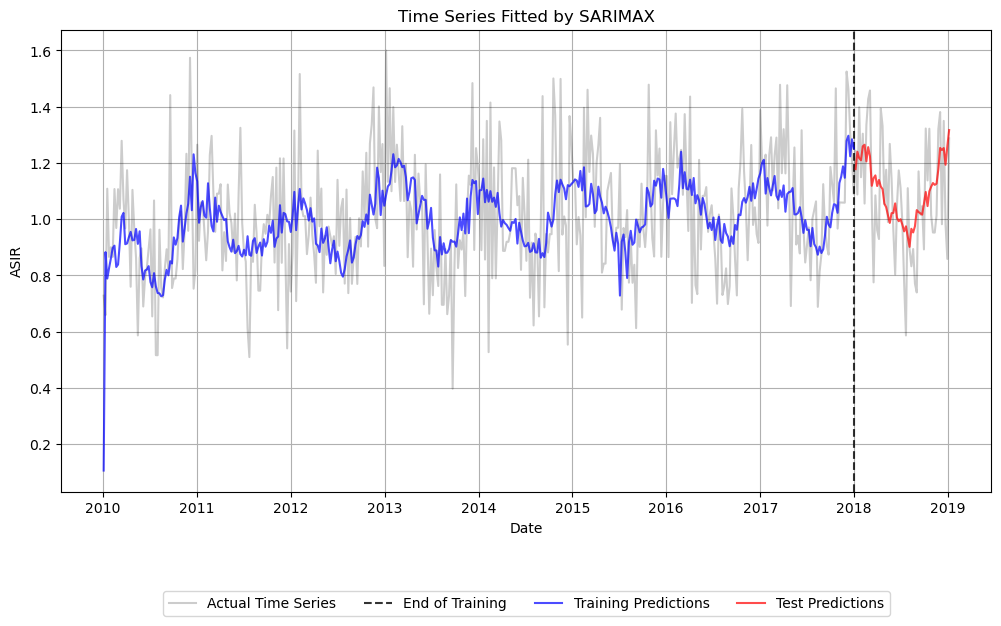

In [11]:
# ===========  SARIMAX MODEL ============
order = (1, 1, 1)  # ARIMA order
seasonal_order = (2, 0, 0, 52)  # Seasonal order

# Fit the SARIMAX model
model = SARIMAX(train['asir'], order = order, seasonal_order = seasonal_order, exog = train[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']])
results = model.fit()

# Print the model summary
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(12, 10))
plt.savefig('plots/AT01_residuals_diag_sarimax.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Make predictions for training data
train_forecast = results.get_prediction(start=train.index[0], end=train.index[-1])
train_forecast_values = train_forecast.predicted_mean
train_forecast_values_original_scale = target_scaler.inverse_transform(train_forecast_values.values.reshape(-1, 1))


# Make predictions for validation data
forecast = results.get_forecast(steps=len(validation), exog=validation[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']])
forecast_values = forecast.predicted_mean
forecast_values_original_scale = target_scaler.inverse_transform(forecast_values.values.reshape(-1, 1))

# Plot actual data
plt.figure(figsize=(12, 6))
plt.plot(data_at01.date, data_at01_mix['asir'], label='Actual Time Series', color='black', alpha=0.2)

# Add vertical line at the end of train
plt.axvline(train.index[-1], color='k', linestyle='--', label='End of Training', alpha=0.8)

# Plot forecasted values for training data
plt.plot(train_forecast_values.index, train_forecast_values_original_scale, label='Training Predictions', color='blue', alpha=0.7)

# Plot forecasted values for validation data
plt.plot(forecast_values.index, forecast_values_original_scale, label='Test Predictions', color='red', alpha=0.7)

# Specify any additional plot settings
plt.xlabel('Date')
plt.ylabel('ASIR')
plt.title('Time Series Fitted by SARIMAX')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)  # ncol sets the number of columns in the legend
plt.savefig('plots/AT01_sarimax_forecast.pdf', format='pdf', bbox_inches='tight')
# Show plot
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.50333D-01    |proj g|=  3.37343D-01

At iterate    5    f= -3.55387D-01    |proj g|=  3.81398D-01

At iterate   10    f= -3.68137D-01    |proj g|=  3.91855D-01

At iterate   15    f= -3.70797D-01    |proj g|=  1.14972D-03

At iterate   20    f= -3.70799D-01    |proj g|=  1.84262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.024D-04  -3.708D-01
  F = -0.37079904028864541     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -3.76411D-01    |proj g|=  8.70368D-01

At iterate   10    f= -4.07436D-01    |proj g|=  2.67433D-01

At iterate   15    f= -4.26202D-01    |proj g|=  2.45091D-01

At iterate   20    f= -4.34127D-01    |proj g|=  1.05143D-01

At iterate   25    f= -4.37511D-01    |proj g|=  3.47871D-02

At iterate   30    f= -4.37926D-01    |proj g|=  1.30043D-02

At iterate   35    f= -4.37975D-01    |proj g|=  1.32047D-03

At iterate   40    f= -4.37980D-01    |proj g|=  3.84353D-03

At iterate   45    f= -4.37982D-01    |proj g|=  2.68541D-04

At iterate   50    f= -4.37982D-01    |proj g|=  6.26345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

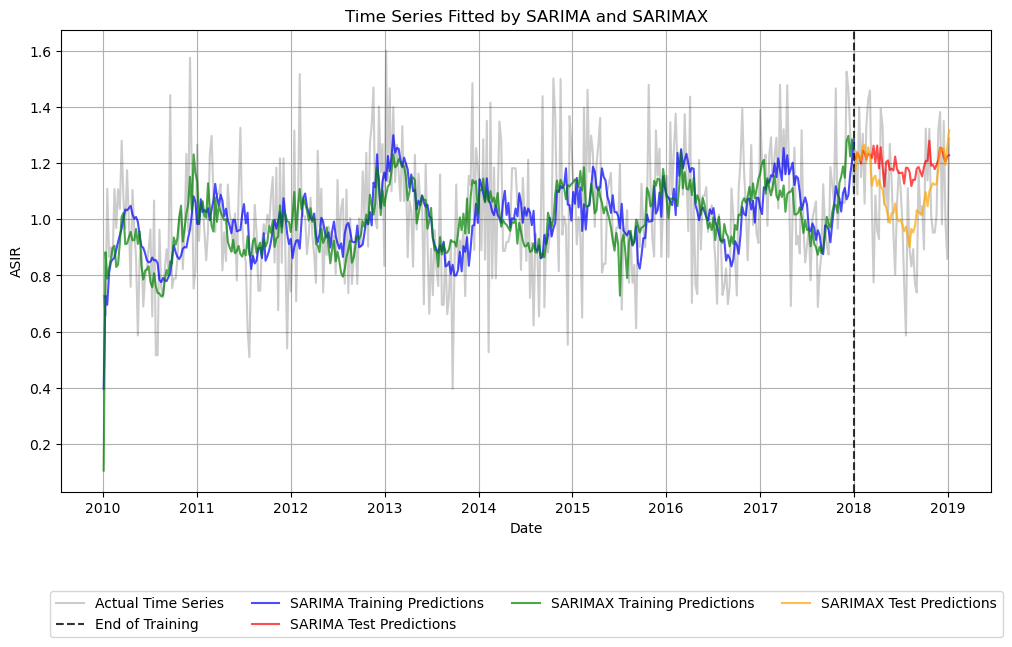

     Model  Training MAE  Training MAPE  Validation MAE  Validation MAPE
0   SARIMA      0.158061       0.166693        0.184483         0.198850
1  SARIMAX      0.148385       0.156761        0.151077         0.151669


In [12]:
# Function to inverse transform the data
def inverse_transform(scaler, data):
    return scaler.inverse_transform(data.values.reshape(-1, 1)).flatten()

# Function to calculate MAE and MAPE
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, mape

# ===========  SARIMA MODEL ============
order = (1, 1, 1)  # ARIMA order
seasonal_order = (2, 0, 0, 52)  # Seasonal order

# Fit the SARIMA model without exogenous data
sarima_model = SARIMAX(train['asir'], order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Make predictions for training data
sarima_train_forecast = sarima_results.get_prediction(start=train.index[0], end=train.index[-1])
sarima_train_forecast_values = sarima_train_forecast.predicted_mean
sarima_train_forecast_values_original_scale = inverse_transform(target_scaler, sarima_train_forecast_values)

# Make predictions for validation data
sarima_forecast = sarima_results.get_forecast(steps=len(validation))
sarima_forecast_values = sarima_forecast.predicted_mean
sarima_forecast_values_original_scale = inverse_transform(target_scaler, sarima_forecast_values)

# ===========  SARIMAX MODEL ============
# Fit the SARIMAX model
sarimax_model = SARIMAX(train['asir'], order=order, seasonal_order=seasonal_order, exog=train[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']])
sarimax_results = sarimax_model.fit()

# Make predictions for training data
sarimax_train_forecast = sarimax_results.get_prediction(start=train.index[0], end=train.index[-1])
sarimax_train_forecast_values = sarimax_train_forecast.predicted_mean
sarimax_train_forecast_values_original_scale = inverse_transform(target_scaler, sarimax_train_forecast_values)

# Make predictions for validation data
sarimax_forecast = sarimax_results.get_forecast(steps=len(validation), exog=validation[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']])
sarimax_forecast_values = sarimax_forecast.predicted_mean
sarimax_forecast_values_original_scale = inverse_transform(target_scaler, sarimax_forecast_values)

# Calculate metrics
sarima_train_mae, sarima_train_mape = calculate_metrics(inverse_transform(target_scaler, train['asir']), sarima_train_forecast_values_original_scale)
sarima_val_mae, sarima_val_mape = calculate_metrics(inverse_transform(target_scaler, validation['asir']), sarima_forecast_values_original_scale)

sarimax_train_mae, sarimax_train_mape = calculate_metrics(inverse_transform(target_scaler, train['asir']), sarimax_train_forecast_values_original_scale)
sarimax_val_mae, sarimax_val_mape = calculate_metrics(inverse_transform(target_scaler, validation['asir']), sarimax_forecast_values_original_scale)

# Print metrics
print("SARIMA Model:")
print(f"Training MAE: {sarima_train_mae}, Training MAPE: {sarima_train_mape}")
print(f"Validation MAE: {sarima_val_mae}, Validation MAPE: {sarima_val_mape}\n")

print("SARIMAX Model:")
print(f"Training MAE: {sarimax_train_mae}, Training MAPE: {sarimax_train_mape}")
print(f"Validation MAE: {sarimax_val_mae}, Validation MAPE: {sarimax_val_mape}\n")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data_at01.date, data_at01_mix['asir'], label='Actual Time Series', color='black', alpha=0.2)
plt.axvline(train.index[-1], color='k', linestyle='--', label='End of Training', alpha=0.8)
plt.plot(sarima_train_forecast_values.index, sarima_train_forecast_values_original_scale, label='SARIMA Training Predictions', color='blue', alpha=0.7)
plt.plot(sarima_forecast_values.index, sarima_forecast_values_original_scale, label='SARIMA Test Predictions', color='red', alpha=0.7)
plt.plot(sarimax_train_forecast_values.index, sarimax_train_forecast_values_original_scale, label='SARIMAX Training Predictions', color='green', alpha=0.7)
plt.plot(sarimax_forecast_values.index, sarimax_forecast_values_original_scale, label='SARIMAX Test Predictions', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('ASIR')
plt.title('Time Series Fitted by SARIMA and SARIMAX')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.savefig('plots/AT01_sarima_sarimax_forecast_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Create a table to compare metrics
comparison_table = pd.DataFrame({
    'Model': ['SARIMA', 'SARIMAX'],
    'Training MAE': [sarima_train_mae, sarimax_train_mae],
    'Training MAPE': [sarima_train_mape, sarimax_train_mape],
    'Validation MAE': [sarima_val_mae, sarimax_val_mae],
    'Validation MAPE': [sarima_val_mape, sarimax_val_mape]
})

print(comparison_table)


In [ ]:
# # ===========  REAL EXAMPLE MOVING PREDICTION ============
# order = (1, 1, 1)  # ARIMA order
# seasonal_order = (2, 0, 0, 52)  # Seasonal order

# # Fit the SARIMAX model
# model = SARIMAX(train['asir'], order=order, seasonal_order=seasonal_order, exog=train[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']])
# results = model.fit()

# # Dynamic predictions for training data
# train_forecast = results.get_prediction(start=train.index[0], end=train.index[-1], dynamic=True)
# train_forecast_values = train_forecast.predicted_mean
# train_forecast_values_original_scale = target_scaler.inverse_transform(train_forecast_values.values.reshape(-1, 1))

# # Dynamic predictions for validation data
# def dynamic_forecast(model, start, steps, exog):
#     predictions = []
#     history = train['asir'].tolist()
#     history_exog = train[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']].values.tolist()
    
#     for t in range(steps):
#         exog_forecast = exog.iloc[t:t+2].values  # use 2-step ahead exogenous variables
#         model = SARIMAX(history, order=order, seasonal_order=seasonal_order, exog=history_exog)
#         results = model.fit(disp=False)
#         yhat = results.forecast(steps=2, exog=exog_forecast)[-1]  # get the t+2 forecast
#         predictions.append(yhat)
#         history.append(yhat)
#         history_exog.append(exog_forecast[-1])
    
#     return predictions

# forecast_values = dynamic_forecast(results, start=train.index[-1] + pd.Timedelta(1, unit='W'), steps=len(validation), exog=validation[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']])
# forecast_values_original_scale = target_scaler.inverse_transform(np.array(forecast_values).reshape(-1, 1))

# # Plot actual data
# plt.figure(figsize=(12, 6))
# plt.plot(data_at01.date, data_at01_mix['asir'], label='Actual Time Series', color='black', alpha=0.2)

# # Add vertical line at the end of train
# plt.axvline(train.index[-1], color='k', linestyle='--', label='End of Training', alpha=0.8)

# # Plot forecasted values for training data
# plt.plot(train_forecast_values.index, train_forecast_values_original_scale, label='Training Predictions', color='blue', alpha=0.7)

# # Plot forecasted values for validation data
# plt.plot(validation.index, forecast_values_original_scale, label='Test Predictions', color='red', alpha=0.7)

# # Specify any additional plot settings
# plt.xlabel('Date')
# plt.ylabel('ASIR')
# plt.title('Time Series Fitted by SARIMAX')
# plt.grid(True)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)  # ncol sets the number of columns in the legend
# #plt.savefig('plots/AT01_sarimax_forecast.pdf', format='pdf', bbox_inches='tight')
# # Show plot
# plt.show()


Evaluating: 100%|██████████| 53/53 [56:19<00:00, 63.77s/it] 


Lead Time: 1 weeks
Mean Absolute Error (MAE): 0.1548577512645086
Root Mean Square Error (RMSE): 0.1548577512645086
Mean Absolute Percentage Error (MAPE): 15.338324491354648%

Lead Time: 15 weeks
Mean Absolute Error (MAE): 0.14527487864071986
Root Mean Square Error (RMSE): 0.14527487864071986
Mean Absolute Percentage Error (MAPE): 14.9183516484761%

Lead Time: 20 weeks
Mean Absolute Error (MAE): 0.1466138371039487
Root Mean Square Error (RMSE): 0.1466138371039487
Mean Absolute Percentage Error (MAPE): 15.56043681753933%

Lead Time: 25 weeks
Mean Absolute Error (MAE): 0.15483998533334717
Root Mean Square Error (RMSE): 0.15483998533334717
Mean Absolute Percentage Error (MAPE): 16.56196925445497%

Lead Time: 30 weeks
Mean Absolute Error (MAE): 0.1456003399248548
Root Mean Square Error (RMSE): 0.1456003399248548
Mean Absolute Percentage Error (MAPE): 14.533817781681224%

Lead Time: 35 weeks
Mean Absolute Error (MAE): 0.16197381704724137
Root Mean Square Error (RMSE): 0.16197381704724137
Mea

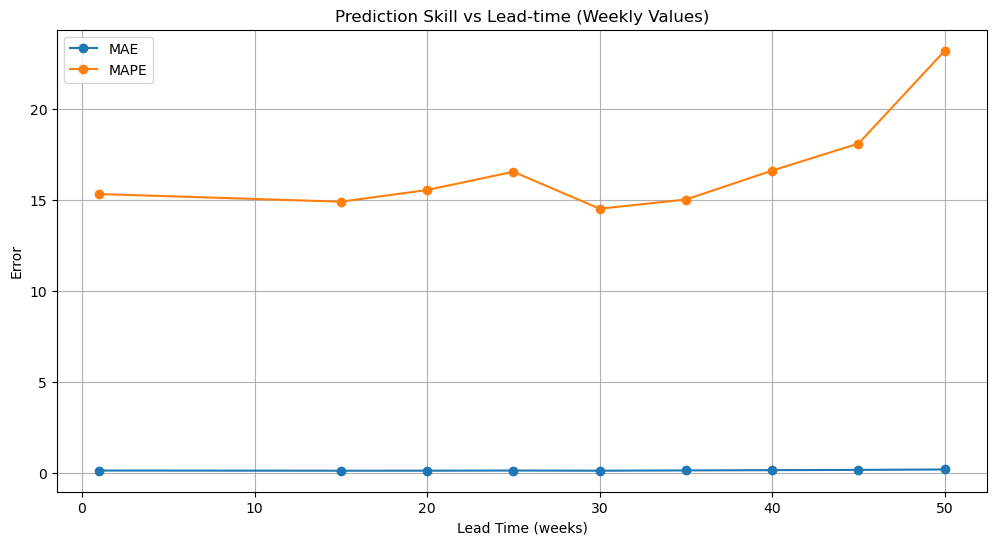

In [19]:
# ===========  PREDICTION SKILL VS LEAD-TIME ============
# Function to calculate performance metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = calculate_mape(actual, predicted)
    return mae, rmse, mape

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Function to perform rolling forecast and evaluate prediction skill vs lead-time
def evaluate_prediction_skill_weekly(train, validation, order, seasonal_order, target_scaler, lead_times=[1, 2, 4, 8]):
    metrics = {lead_time: {'mae': [], 'rmse': [], 'mape': []} for lead_time in lead_times}
    
    history = train['asir'].tolist()
    history_exog = train[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']].values.tolist()
    
    for t in tqdm(range(len(validation)), desc='Evaluating'):
        exog_forecast = validation[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']].iloc[t:t+max(lead_times)].values
        
        # Update model with the current history
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order, exog=history_exog)
        results = model.fit(disp=False)
        
        for lead_time in lead_times:
            if t + lead_time < len(validation):
                yhat = results.forecast(steps=lead_time, exog=exog_forecast[:lead_time])[-1]
                actual = validation['asir'].iloc[t + lead_time]
                
                # Inverse transform the predictions to the original scale
                yhat_original_scale = target_scaler.inverse_transform(np.array(yhat).reshape(-1, 1)).flatten()[0]
                actual_original_scale = target_scaler.inverse_transform(np.array(actual).reshape(-1, 1)).flatten()[0]
                
                mae, rmse, mape = calculate_metrics([actual_original_scale], [yhat_original_scale])
                metrics[lead_time]['mae'].append(mae)
                metrics[lead_time]['rmse'].append(rmse)
                metrics[lead_time]['mape'].append(mape)
        
        # Update history with the new weekly observation
        history.append(validation['asir'].iloc[t])
        history_exog.append(exog_forecast[0])
    
    # Aggregate metrics for each lead time
    for lead_time in lead_times:
        metrics[lead_time]['mae'] = np.mean(metrics[lead_time]['mae'])
        metrics[lead_time]['rmse'] = np.mean(metrics[lead_time]['rmse'])
        metrics[lead_time]['mape'] = np.mean(metrics[lead_time]['mape'])
    
    return metrics

# Define SARIMAX model parameters
order = (1, 1, 1)
seasonal_order = (2, 0, 0, 52)

# Perform evaluation
lead_times = [1, 15, 20, 25, 30, 35, 40, 45, 50]  # lead times
metrics = evaluate_prediction_skill_weekly(train, validation, order, seasonal_order, target_scaler, lead_times)

# Print the results
for lead_time in lead_times:
    print(f"Lead Time: {lead_time} weeks")
    print(f"Mean Absolute Error (MAE): {metrics[lead_time]['mae']}")
    print(f"Root Mean Square Error (RMSE): {metrics[lead_time]['rmse']}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics[lead_time]['mape']}%\n")

# Plot the metrics
lead_times = list(metrics.keys())
mae_values = [metrics[lt]['mae'] for lt in lead_times]
rmse_values = [metrics[lt]['rmse'] for lt in lead_times]
mape_values = [metrics[lt]['mape'] for lt in lead_times]

plt.figure(figsize=(12, 6))
plt.plot(lead_times, mae_values, marker='o', label='MAE')
plt.plot(lead_times, mape_values, marker='o', label='MAPE')
plt.xlabel('Lead Time (weeks)')
plt.ylabel('Error')
plt.title('Prediction Skill vs Lead-time (Weekly Values)')
plt.grid(True)
plt.legend()
plt.savefig('plots/Prediction_skill_vs_lead_time_weekly.pdf', format='pdf', bbox_inches='tight')
plt.show()

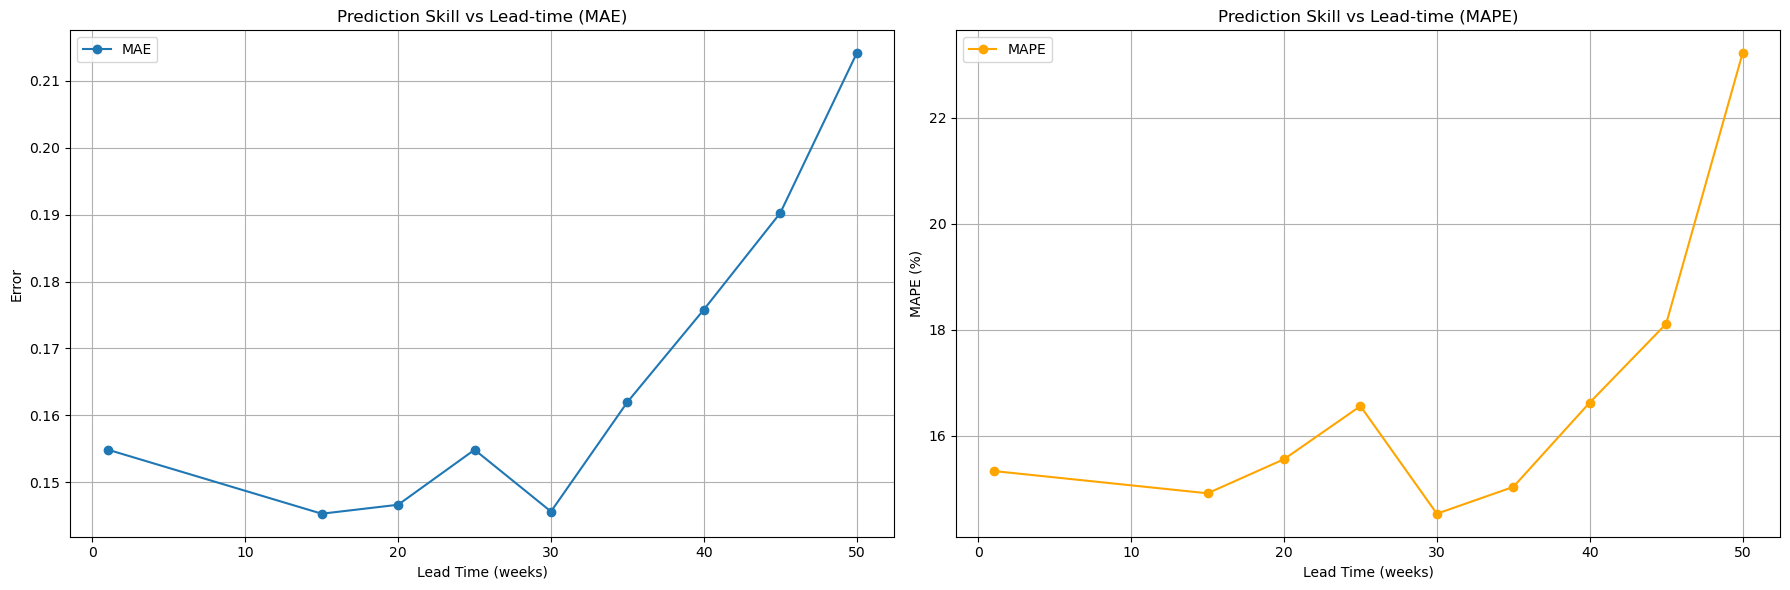

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Subfigure 1: MAE and RMSE
ax1.plot(lead_times, mae_values, marker='o', label='MAE')
#ax1.plot(lead_times, rmse_values, marker='o', label='RMSE')
ax1.set_xlabel('Lead Time (weeks)')
ax1.set_ylabel('Error')
ax1.set_title('Prediction Skill vs Lead-time (MAE)')
ax1.grid(True)
ax1.legend()

# Subfigure 2: MAPE
ax2.plot(lead_times, mape_values, marker='o', label='MAPE', color='orange')
ax2.set_xlabel('Lead Time (weeks)')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('Prediction Skill vs Lead-time (MAPE)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.savefig('plots/Prediction_skill_vs_lead_time_weekly.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# # ===========  SARIMAX MODEL TUNING ============
# class SARIMAXWrapper(BaseEstimator, RegressorMixin):
#     def __init__(self, p=1, d=1, q=1, P=1, D=1, Q=1, s=52):
#         self.p = p
#         self.d = d
#         self.q = q
#         self.P = P
#         self.D = D
#         self.Q = Q
#         self.s = s
#         self.model_ = None

#     def fit(self, X, y=None):
#         self.model_ = SARIMAX(endog=y, exog=X, order=(self.p, self.d, self.q),
#                               seasonal_order=(self.P, self.D, self.Q, self.s)).fit(disp=False)
#         return self

#     def predict(self, X):
#         return self.model_.forecast(steps=len(X), exog=X)

#     def score(self, X, y):
#         predictions = self.predict(X)
#         return -np.mean((predictions - y) ** 2)  # negative MSE

# # Define the parameter grid
# p_values = list(range(0, 3))
# d_values = list(range(0, 2))
# q_values = list(range(0, 3))
# P_values = list(range(0, 2))
# D_values = list(range(0, 2))
# Q_values = list(range(0, 3))
# s_values = [52]

# param_grid = [{
#     'p': p,
#     'd': d,
#     'q': q,
#     'P': P,
#     'D': D,
#     'Q': Q,
#     's': s
# } for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values)]

# # Time series cross-validator
# tscv = TimeSeriesSplit(n_splits=3)

# X = train[['temp', 'hum', 'is_holiday', 'pm10', 'no2', 'so2', 'co']]
# y = train['asir']

# # Perform grid search manually with progress bar
# best_score = float('-inf')
# best_params = None
# results = []

# total_iterations = len(param_grid) * tscv.get_n_splits(X, y)

# with tqdm(total=total_iterations, desc="GridSearchCV") as pbar:
#     for params in param_grid:
#         cv_scores = []
#         for train_index, test_index in tscv.split(X):
#             X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#             y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#             model = SARIMAXWrapper(**params)
#             model.fit(X_train, y_train)
#             score = model.score(X_test, y_test)
#             cv_scores.append(score)
#             pbar.update(1)

#         mean_cv_score = np.mean(cv_scores)
#         results.append({
#             **params,
#             'score': mean_cv_score
#         })

#         if mean_cv_score > best_score:
#             best_score = mean_cv_score
#             best_params = params

# print("Best parameters:", best_params)
# # Store the results in a DataFrame
# results_df = pd.DataFrame(results)

# # Save the results to a CSV file
# results_df.to_csv('sarimax_tuning/AT01_grid_search_results.csv', index=False)
# print("Grid search results saved to 'sarimax_tuning/AT01_grid_search_results.csv'")

# results_df = pd.read_csv('sarimax_tuning/AT01_grid_search_results.csv')
# results_df.sort_values('score')

In [15]:
# Calculate evaluation metrics
mae = mean_absolute_error(validation['asir'], forecast_values)
mse = mean_squared_error(validation['asir'], forecast_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((validation['asir'] - forecast_values) / validation['asir'])) * 100

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Akaike Information Criterion (AIC):", results.aic)
print("Bayesian Information Criterion (BIC):", results.bic)

Mean Absolute Error (MAE): 0.12378596254426608
Mean Squared Error (MSE): 0.021186108089576106
Root Mean Squared Error (RMSE): 0.14555448495177367
Mean Absolute Percentage Error (MAPE): 26.593218205921172
Akaike Information Criterion (AIC): -327.8575779987494
Bayesian Information Criterion (BIC): -291.55980200256016


# SCRIPTS

In [ ]:

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False, sharey=False)

# Subplot for AT01
axes[0].plot(data_at01['date'], data_at01['asir'], label='ACTUAL', alpha=0.3)
axes[0].plot(data_at01['date'], data_at01['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[0].plot(data_at01['date'], data_at01['b_asir_30'], label='MA (30days)', alpha=1)
axes[0].plot(data_at01['date'], data_at01['a_asir_90'], label='MA (90days)', alpha=0.6)
#axes[0].plot(data_at01['date'], data_at01['b_asir_365'], label='asir_365', alpha=0.6)
axes[0].set_title('Daily Age Standardised Incidence Rate for AT01')

# Subplot for AT02
axes[1].plot(data_at03['date'], data_at03['asir'], label='ACTUAL', alpha=0.3)
axes[1].plot(data_at03['date'], data_at03['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[1].plot(data_at03['date'], data_at03['b_asir_30'], label='MA (30days)', alpha=1)
axes[1].plot(data_at03['date'], data_at03['a_asir_90'], label='MA (90days)', alpha=0.6)
#axes[1].plot(data_at03['date'], data_at03['b_asir_365'], label='asir_365', alpha=0.6)
axes[1].set_title('Daily Age Standardised Incidence Rate for AT03')
axes[1].grid(True)

# Set x-axis to show every second year
for ax in axes:
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.grid(which='major', linestyle='--', linewidth=0.5)  # Minor grid style


# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'ASIR values', ha='center', va='center', rotation='vertical')

# Save the plot as a PDF file
plt.savefig('../plots/asir_plots_daily.pdf', format='pdf', bbox_inches='tight')
plt.show()
# Filter data for AT01 and AT03
data_at01 = data[data['at_code'] == 'AT01'][['date', 'max_hum', 'min_hum', 'max_temp', 'min_temp','a_asir_90', 'b_asir_365', 'c_asir_5', 'b_asir_30', 'asir', 'is_holiday', 'mean_O3', 'mean_PM10']]
data_at03 = data[data['at_code'] == 'AT03'][['date', 'max_hum', 'min_hum', 'max_temp', 'min_temp','a_asir_90', 'b_asir_365', 'c_asir_5', 'b_asir_30', 'asir', 'is_holiday', 'mean_O3', 'mean_PM10']]

# Define custom aggregation functions
custom_agg_functions = {
    'max_hum': 'max',
    'min_hum': 'min',
    'max_temp': 'max',
    'min_temp': 'min',
    'a_asir_90': 'mean',
    'b_asir_365': 'mean',
    'c_asir_5': 'mean',
    'b_asir_30': 'mean',
    'asir': 'mean',
    'is_holiday': 'max',
    'mean_O3' : 'mean',
    'mean_PM10' : 'mean'
}

# Aggregate data to weekly values
data_at01_weekly = data_at01.resample('W', on='date').agg(custom_agg_functions)
data_at03_weekly = data_at03.resample('W', on='date').agg(custom_agg_functions)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False, sharey=False)

# Subplot for AT01
axes[0].plot(data_at01_weekly.index, data_at01_weekly['asir'], label='ACTUAL', alpha=0.3)
axes[0].plot(data_at01_weekly.index, data_at01_weekly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[0].plot(data_at01_weekly.index, data_at01_weekly['b_asir_30'], label='MA (30days)', alpha=1)
axes[0].plot(data_at01_weekly.index, data_at01_weekly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[0].set_title('Weekly Age Standardised Incidence Rate for AT01')

# Subplot for AT02
axes[1].plot(data_at03_weekly.index, data_at03_weekly['asir'], label='ACTUAL', alpha=0.3)
axes[1].plot(data_at03_weekly.index, data_at03_weekly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[1].plot(data_at03_weekly.index, data_at03_weekly['b_asir_30'], label='MA (30days)', alpha=1)
axes[1].plot(data_at03_weekly.index, data_at03_weekly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[1].set_title('Weekly Age Standardised Incidence Rate for AT03')
axes[1].grid(True)

# Set x-axis to show every second year
for ax in axes:
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.grid(which='major', linestyle='--', linewidth=0.5)  # Minor grid style

# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'ASIR values', ha='center', va='center', rotation='vertical')

# Save the plot as a PDF file
plt.savefig('../plots/asir_plots_weekly.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Aggregate data to monthly values
data_at01_monthly = data_at01.resample('M', on='date').agg(custom_agg_functions)
data_at03_monthly = data_at03.resample('M', on='date').agg(custom_agg_functions)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False, sharey=False)

# Subplot for AT01
axes[0].plot(data_at01_monthly.index, data_at01_monthly['asir'], label='ACTUAL', alpha=0.3)
axes[0].plot(data_at01_monthly.index, data_at01_monthly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[0].plot(data_at01_monthly.index, data_at01_monthly['b_asir_30'], label='MA (30days)', alpha=1)
axes[0].plot(data_at01_monthly.index, data_at01_monthly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[0].set_title('Monthly Age Standardised Incidence Rate for AT01')

# Subplot for AT02
axes[1].plot(data_at03_monthly.index, data_at03_monthly['asir'], label='ACTUAL', alpha=0.3)
axes[1].plot(data_at03_monthly.index, data_at03_monthly['c_asir_5'], label='MA (5days)', alpha=0.6)
axes[1].plot(data_at03_monthly.index, data_at03_monthly['b_asir_30'], label='MA (30days)', alpha=1)
axes[1].plot(data_at03_monthly.index, data_at03_monthly['a_asir_90'], label='MA (90days)', alpha=0.6)
axes[1].set_title('Monthly Age Standardised Incidence Rate for AT03')
axes[1].grid(True)

# Set x-axis to show every second year
for ax in axes:
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.grid(which='major', linestyle='--', linewidth=0.5)  # Minor grid style

# Create a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'ASIR values', ha='center', va='center', rotation='vertical')

# Save the plot as a PDF file
plt.savefig('../plots/asir_plots_monthly.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# =========== FORECASTER AND FEATURE IMPORTANCE ============
# Create and fit forecaster
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=15
)

forecaster.fit(
    y=train['asir'],
    exog=train[['temp', 'hum', 'is_holiday', 'month', 'year', 'pm10', 'o3', 'no2', 'so2', 'co']]
)

# Reset index of validation DataFrame
validation_reset = validation.reset_index(drop=True)

# Predict
steps = len(validation_reset)
predictions_scaled = forecaster.predict(
    steps=steps,
    exog=validation_reset[['temp', 'hum', 'is_holiday', 'month', 'year', 'pm10', 'o3', 'no2', 'so2', 'co']],
    last_window=None  # Assuming last_window=None for initial prediction
)


# Inverse transform predictions to original scale
predictions_scaled_np = predictions_scaled.to_numpy().reshape(-1, 1)
predictions = target_scaler.inverse_transform(predictions_scaled_np)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
train_original = target_scaler.inverse_transform(train['asir'].values.reshape(-1, 1))
validation_original = target_scaler.inverse_transform(validation['asir'].values.reshape(-1, 1))

ax.plot(train.index, train_original, label='train')
ax.plot(validation.index, validation_original, label='test')
ax.plot(validation.index, predictions, label='predictions')
ax.legend()

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = validation_original,
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

# Feature importances with exogenous variables
# ==============================================================================
feature_importances = forecaster.get_feature_importances()
print("Feature importances:\n", feature_importances)
# =========== BACKTESTING ============
# Data preprocessing
# ==============================================================================
data = df_f_scaled
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2017-12-31'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 4
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['asir'],
                          exog                  = data[['max_temp', 'min_hum', 'mean_PM10', 'mean_O3', 'is_holiday']],
                          steps                 = 2,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = 12,
                          n_jobs                = 'auto',
                          interval              = [5, 95],
                          verbose               = True,
                          show_progress         = True  
                      )
# Backtest error
# ==============================================================================
print(f"Backtest error: {metric}")

# Plot prediction intervals
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:, 'asir'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend()